# Project 2 - Medical Malpractice Insurance Claims

## Table of Contents
1. [Dataset Overview](#Dataset-Overview)
2. [Data Statistics](#Data-Statistics)
    - [Amount](#Amount)
    - [Severity](#Severity)
    - [Age](#Age)
    - [Private Attorney](#Private-Attorney)
    - [Specialty](#Specialty)
    - [Insurance](#Insurance)
    - [Gender](#Gender)
3. [Data Cleaning](#Data-Cleaning)
    - [Removing Duplicate rows](#Removing-Duplicate-rows)
    - [Checking for null values](#Checking-for-null-values)
    - [Outliers](#Outliers)
    - [Other Modifications](#Other-Modifications)
4. [EDA](#EDA)
    - [Feature Correlation](#Feature-Correlation)
    - [Feature Correlation Using One-Hot Encoding](#Feature-Correlation-Using-One-Hot-Encoding)
    - [Questions for Analysis](#Questions-for-Analysis)
    - [Strongest Predictors of Amounts Amongst High and Low-payment Groups](#Question-1)
    - [Hypothesis Testing using Mann-Whitney-U test](#Question-2)
    - [Predicting Amount using Regression Models](#Question-3)
5. [Conclusions](#Conclsions)


## Dataset Overview

Medical malpratice is when a healthcare provider fails to act in accordance with professional standards that leads to a loss of a patient. Medical malpractice insurance both protects healthcare providers from lawsuits and allows for the injured party to sue for damages when malpractice occurs.

For this project we'll be using a data set focused on medical malpractice insurance claims.

[A detailed overview of the dataset can be found here](https://www.kaggle.com/datasets/gabrielsantello/medical-malpractice-insurance-dataset/data)

Our data set contains information about the last 79210 claim payments made.

- **Amount** - Amount of the claim payment in dollars
- **Severity** - The severity rating of damage to the patient, from 1 (emotional trauma) to 9 (death)
- **Age** - Age of the claimant in years
- **Private Attorney** - Whether the claimant was represented by a private attorney
- **Marital Status** - Marital status of the claimant (0 (Divorced), 1 (Single), 2 (Married), 3 (Widowed), 4 (Unknown))
- **Specialty** - Specialty of the physician involved in the lawsuit
- **Insurance** - Type of medical insurance carried by the patient
- **Gender** - Patient Gender

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
df = pd.read_csv('./input_data/medicalmalpractice.csv')
df.head()

,Amount,Severity,Age,Private Attorney,Marital Status,Specialty,Insurance,Gender
0,57041,7,62,1,2,Family Practice,Private,Male
1,324976,6,38,1,2,OBGYN,No Insurance,Female
2,135383,4,34,1,2,Cardiology,Unknown,Male
3,829742,7,42,1,1,Pediatrics,No Insurance,Female
4,197675,3,60,0,2,OBGYN,Medicare/Medicaid,Female


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79210 entries, 0 to 79209
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Amount            79210 non-null  int64 
 1   Severity          79210 non-null  int64 
 2   Age               79210 non-null  int64 
 3   Private Attorney  79210 non-null  int64 
 4   Marital Status    79210 non-null  int64 
 5   Specialty         79210 non-null  object
 6   Insurance         79210 non-null  object
 7   Gender            79210 non-null  object
dtypes: int64(5), object(3)
memory usage: 4.8+ MB


In [4]:
df.shape

(79210, 8)

Our data set contains 79210 rows and 8 different columns. The `.info` function tells us that `Amount`,`Severity`,`Age`,`Private Attorney`, and `Marital Status` all contain numeric data, while `Specialty`,`Insurance`, and `Gender` contain object data types.

Let's run our pairplot function to gain a better understanding of our numeric columns

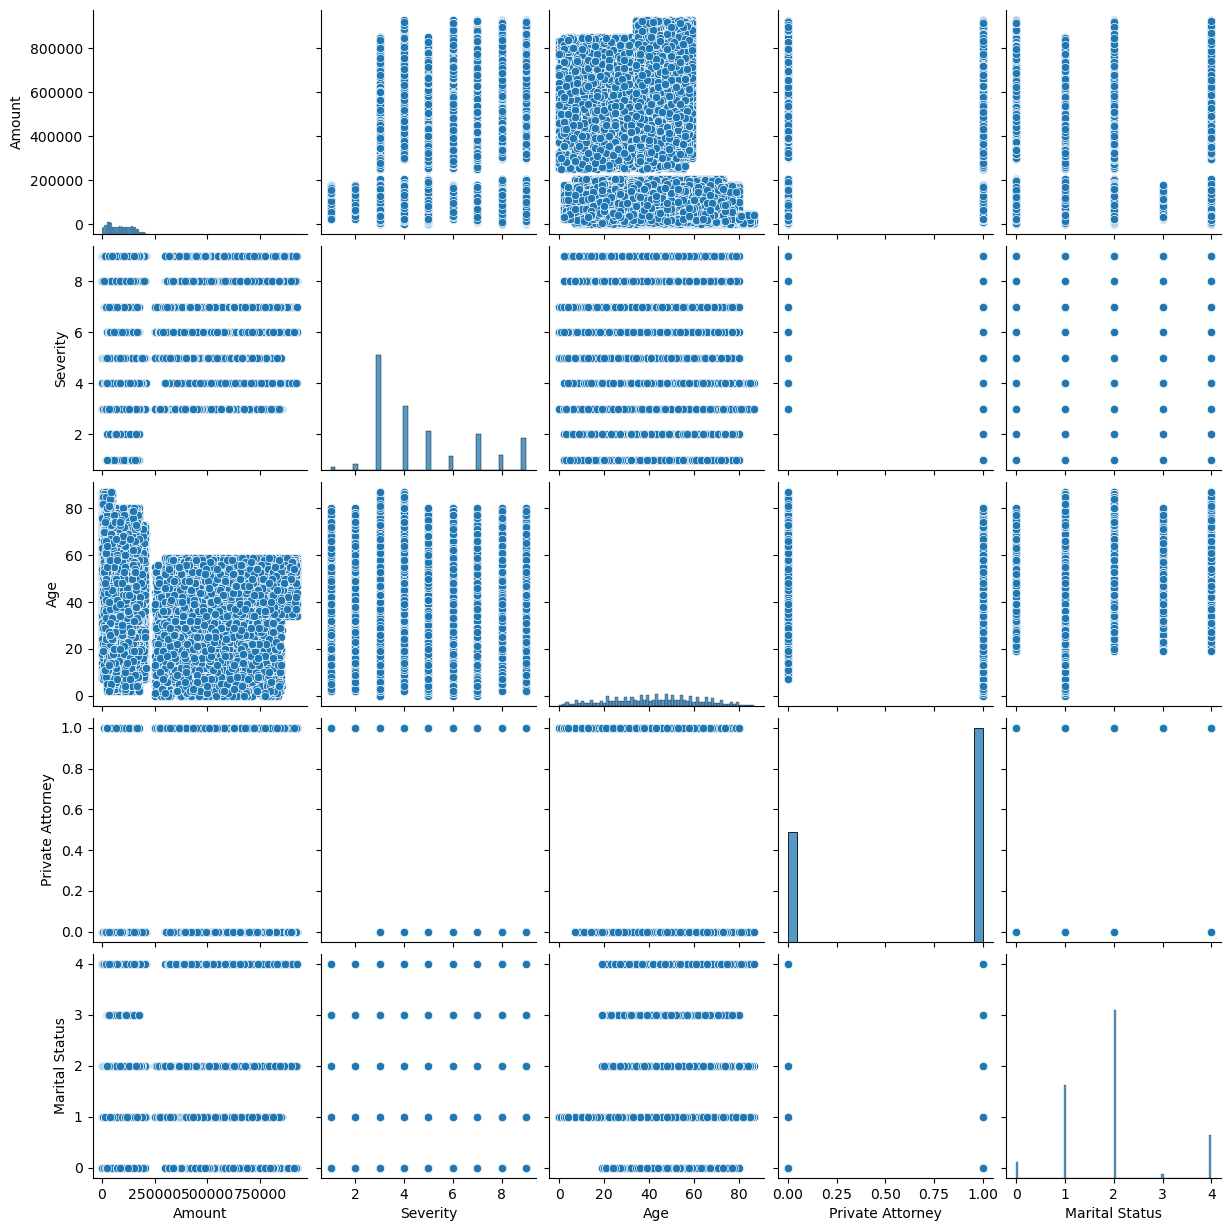

In [5]:
sns.pairplot(df)

<Axes: >

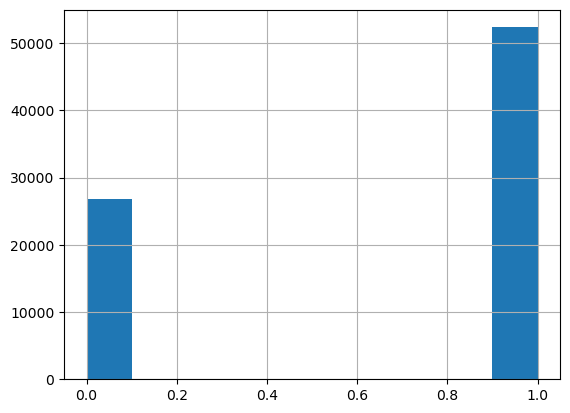

In [6]:
df['Private Attorney'].hist()

One thing that may represent a data balance issue, is that our data set contains roughly twice as many rows where private attorney is True

<Axes: >

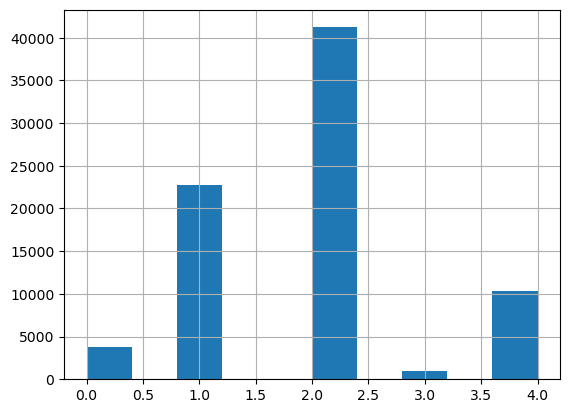

In [7]:
df['Marital Status'].hist()

Note that the `Marital Status` column contains numeric categorical data from 0 to 4 and should not be considered scalar. the values for the marital status are: 

- 0 : Divorced
- 1 : Single
- 2 : Married
- 3 : Widowed
- 4 : Unknown

<Axes: >

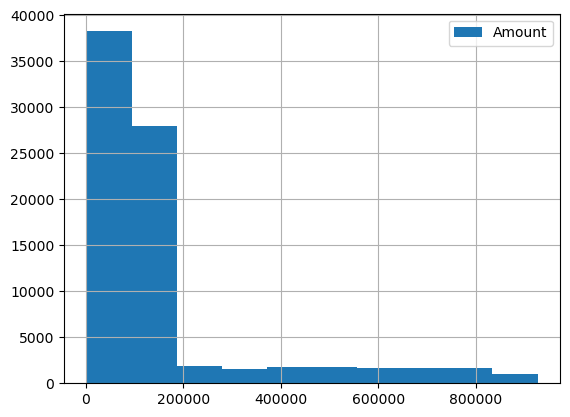

In [77]:
df['Amount'].hist()

We can see that the `Amount` column contains the majority of data with the claim paid being less than 200,000 dollars. However, there is a significant slice of data containing claim payments above 200,000 dollars.

<Axes: >

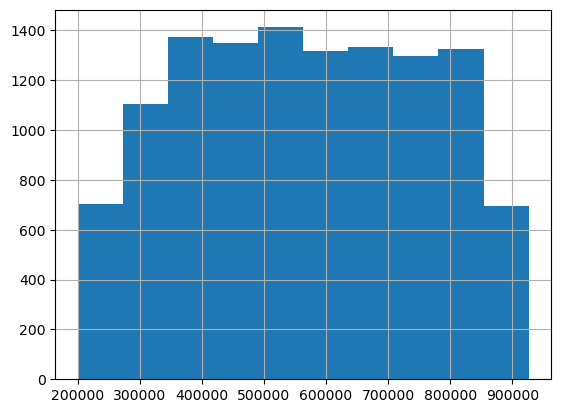

In [9]:
df[df.Amount >= 200000].Amount.hist()

The `Amount` data appears more normally distributed when isolating only the claims with payouts 200,000 dollars or more.

<Axes: >

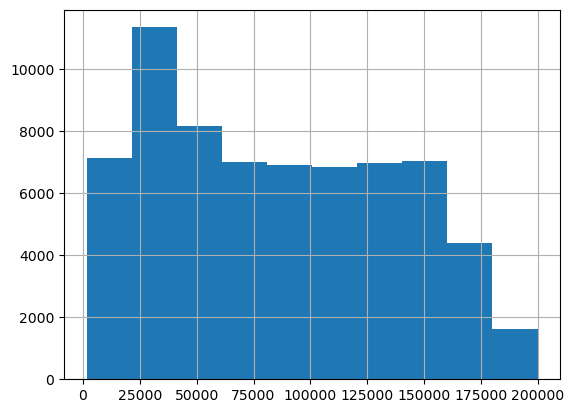

In [10]:
df[df.Amount < 200000].Amount.hist()

Again, our data appears normally distributed with a slight right skew for claims below 200,000 dollars. It may prove useful to analyze these two groups seperately later on. 

Let's add a categorical column to our dataframe named `large_pmt` to seperate these two groups. if there was a payment of over 200k dollars, the `large_pmt` value will be true, or 1. 

In [11]:
df['large_pmt']=0
df.loc[df.Amount >= 200000,'large_pmt']=1
df.head()

,Amount,Severity,Age,Private Attorney,Marital Status,Specialty,Insurance,Gender,large_pmt
0,57041,7,62,1,2,Family Practice,Private,Male,0
1,324976,6,38,1,2,OBGYN,No Insurance,Female,1
2,135383,4,34,1,2,Cardiology,Unknown,Male,0
3,829742,7,42,1,1,Pediatrics,No Insurance,Female,1
4,197675,3,60,0,2,OBGYN,Medicare/Medicaid,Female,0


Let's re-run our pairplot function and add a hue layer for large payments to see if we notice any patterns. 

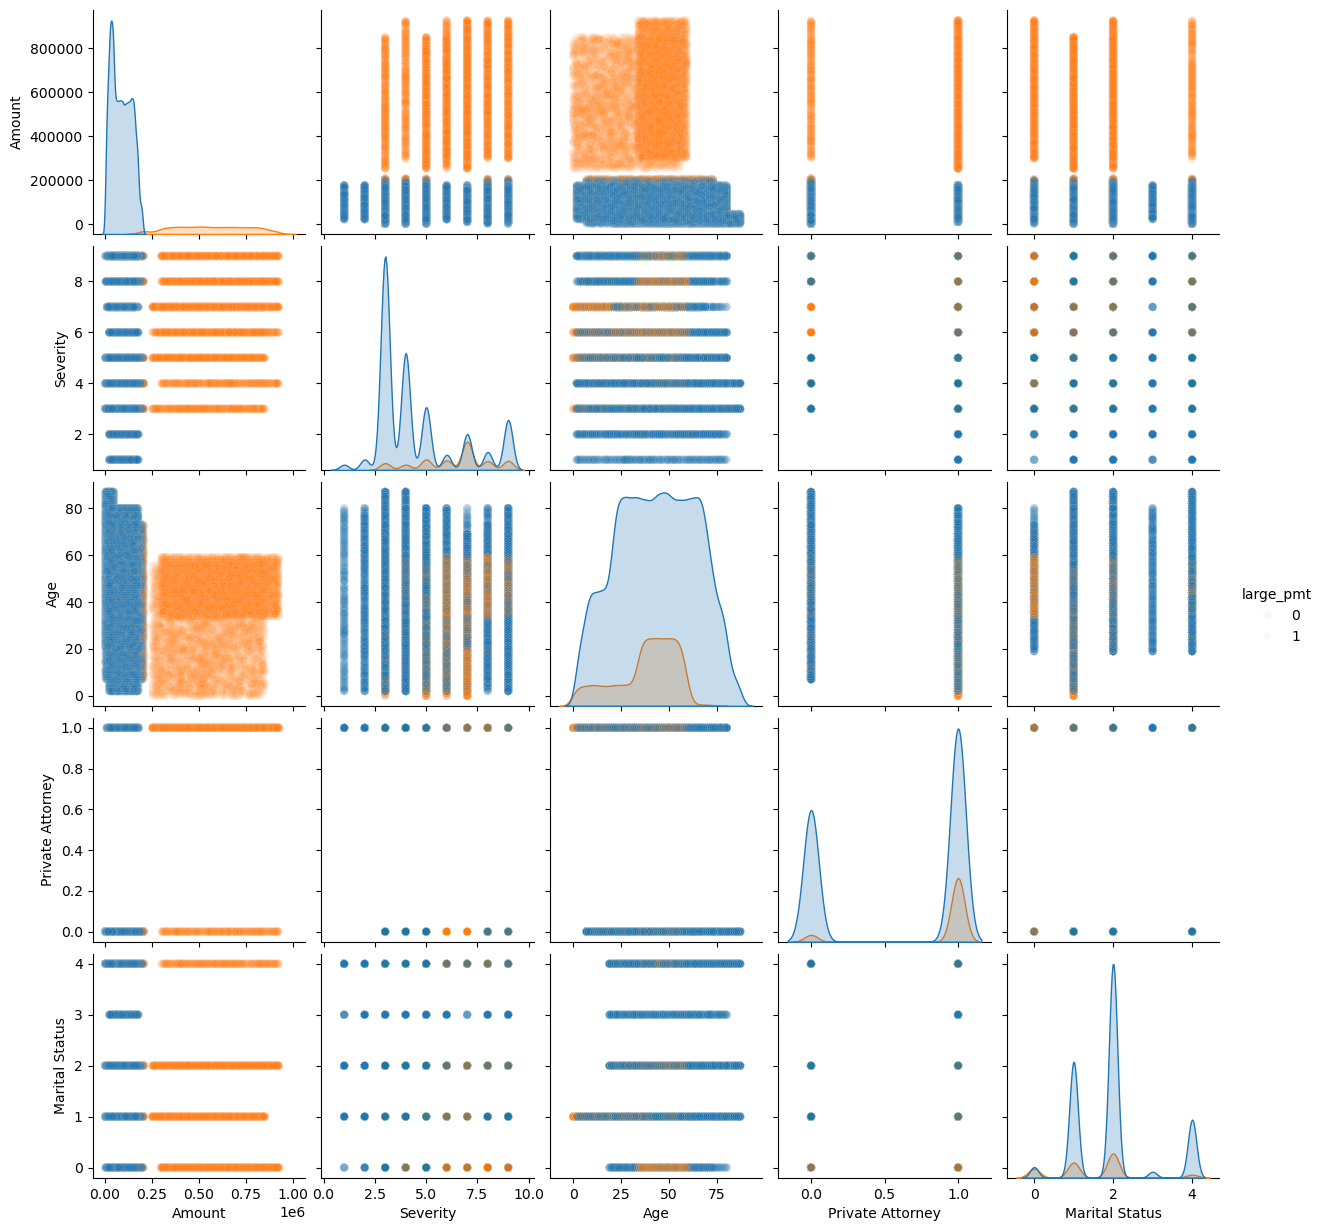

In [12]:
sns.pairplot(data = df[['Amount','Severity','Age','Private Attorney','Marital Status','large_pmt']], 
             hue = 'large_pmt', 
             plot_kws = {'alpha' : .05},
             kind = 'scatter')

Already, we can tell that claim payments above 200,000 dollars have a higher proportion of claimants represented by private attorneys. It also appears that the average severity of injuries is higher for claimants with large claim payments. It also appears that there may be a positive linear relationship between age and severity amongst large payment claims, but it's not as clear.

We'll revisit some of these relationships when we dive deeper into our analysis later on.

## Data Statistics

Let's move on and review some of the statistical charactaristics of our data

In [13]:
df_stats = df.describe(include='all')
df_stats

,Amount,Severity,Age,Private Attorney,Marital Status,Specialty,Insurance,Gender,large_pmt
count,79210.000000,79210.000000,79210.000000,79210.000000,79210.000000,79210,79210,79210,79210.000000
unique,NaN,NaN,NaN,NaN,NaN,20,5,2,NaN
top,NaN,NaN,NaN,NaN,NaN,Family Practice,Private,Female,NaN
freq,NaN,NaN,NaN,NaN,NaN,11436,34289,47770,NaN
mean,157484.554816,4.799659,42.701868,0.660889,1.889559,NaN,NaN,NaN,0.150284
std,193135.093293,2.083439,19.811063,0.473411,1.002502,NaN,NaN,NaN,0.357352
min,1576.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000
25%,43670.250000,3.000000,28.000000,0.000000,1.000000,NaN,NaN,NaN,0.000000
50%,98131.000000,4.000000,43.000000,1.000000,2.000000,NaN,NaN,NaN,0.000000
75%,154675.250000,7.000000,58.000000,1.000000,2.000000,NaN,NaN,NaN,0.000000


We'll export our statistics to to our output_folder:

In [14]:
df_stats.to_csv('./output_data/df_stats.csv')

### Columns

#### Amount

The mean claim payment made in our data is 157,484 dollars.

<Axes: xlabel='Amount'>

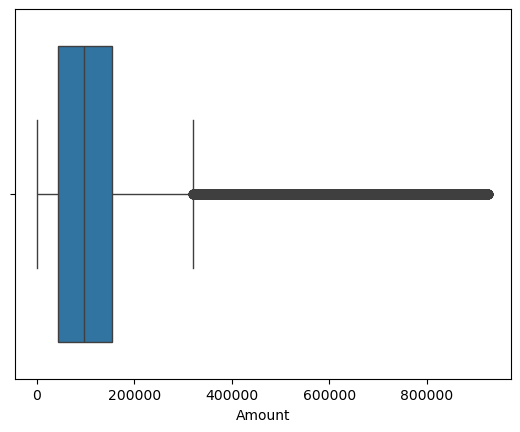

In [15]:
sns.boxplot(df['Amount'], orient='h')

In [16]:
print(f'The median amount of claim paid is: {df.Amount.median()} dollars')

The median amount of claim paid is: 98131.0 dollars


Again we can see that our data is right-skewed, and the much of our data falls outside 1.5x the IQR from the 75th percentile and considered outliers.

#### Severity

The severity value is a scale from 1 to 9, 1 being emotional trauma, and 9 being fatality. Our data source doesn't say exactly how this figure was collected or any more details about the specific ratings. Overall, I am skeptical about how reliable the rating is. 

<Axes: xlabel='Severity'>

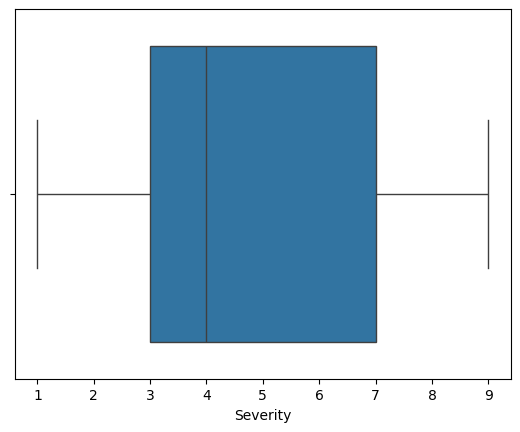

In [17]:
sns.boxplot(df['Severity'], orient='h')

In [18]:
print(f'The median severity rating is: {df.Severity.median()}')

The median severity rating is: 4.0


It appears that the Severity rating is pretty evenly distributed without any notable outliers.

#### Age

In [19]:
df.Age.describe()

count    79210.000000
mean        42.701868
std         19.811063
min          0.000000
25%         28.000000
50%         43.000000
75%         58.000000
max         87.000000
Name: Age, dtype: float64

The ages in our data range from 0 to 87 with the mean being 43. These values appear reasonable with no apparent outliers.

<Axes: xlabel='Age'>

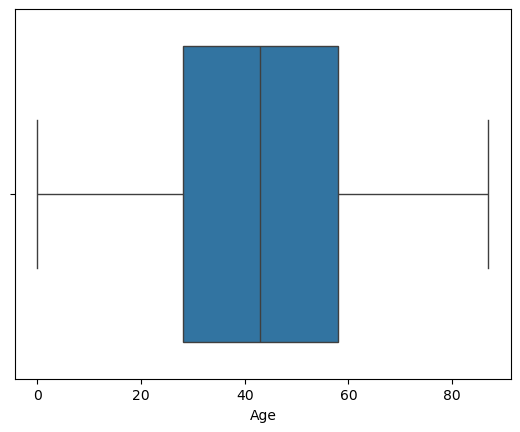

In [20]:
sns.boxplot(df.Age, orient = 'h')

In [21]:
print(f'The median age is: {df.Age.median()}')

The median age is: 43.0


<Axes: xlabel='Age', ylabel='Gender'>

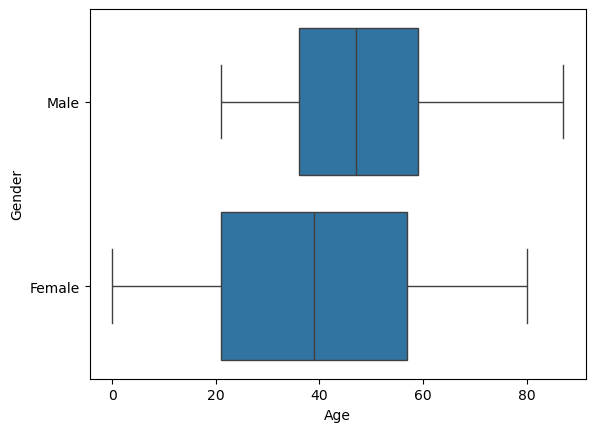

In [22]:
sns.boxplot(df, x = 'Age' , y = 'Gender', orient='h')

When splitting our age data by gender, we can see there is a difference in the distribution of ages between male and female claimants.

In [23]:
df.groupby('Gender').Age.describe().T

Gender,Female,Male
count,47770.000000,31440.000000
mean,39.167448,48.072074
std,21.420559,15.615303
min,0.000000,21.000000
25%,21.000000,36.000000
50%,39.000000,47.000000
75%,57.000000,59.000000
max,80.000000,87.000000


Males in our data set on average are older. The mean age for Males is 47 and the mean age for Females is 39. Additionaly the minimum age in our data set for males is 21 which is notably higher compared to the Female data, which begins at age 0.

#### Private Attorney

The Private Attorney column in our dataframe contains either a 0 or 1 that represents whether or not the claimant had private counsel to resolve their claim

In [24]:
df['Private Attorney'].describe()

count    79210.000000
mean         0.660889
std          0.473411
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Private Attorney, dtype: float64

The mean in this column, .66, can be interpreted that 66% of the data is made up of claimants with a private attorney.

<Axes: xlabel='Private Attorney', ylabel='Count'>

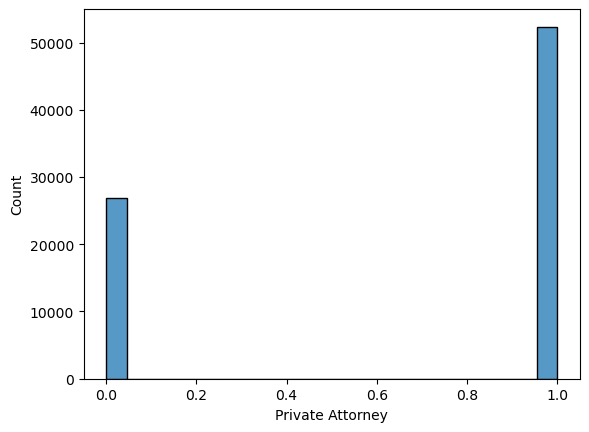

In [25]:
sns.histplot(df['Private Attorney'])

The majority of the claimants in our data set are represented by a private attorney. 

In [26]:
df.groupby('large_pmt')['Private Attorney'].describe().T

large_pmt,0,1
count,67306.000000,11904.000000
mean,0.618162,0.902470
std,0.485841,0.296691
min,0.000000,0.000000
25%,0.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


When seperating the data into groups by payment size, we can see that claimants with private attorneys make up 90% of the groups with payments above 200,000 dollars

In [27]:
df.groupby('Private Attorney')['Amount'].describe().T

Private Attorney,0,1
count,26861.000000,52349.000000
mean,86869.740516,193717.998185
std,106594.316916,216193.544094
min,1576.000000,10505.000000
25%,23832.000000,65259.000000
50%,46444.000000,113823.000000
75%,130183.000000,163301.000000
max,924229.000000,926411.000000


<Axes: xlabel='Private Attorney', ylabel='Amount'>

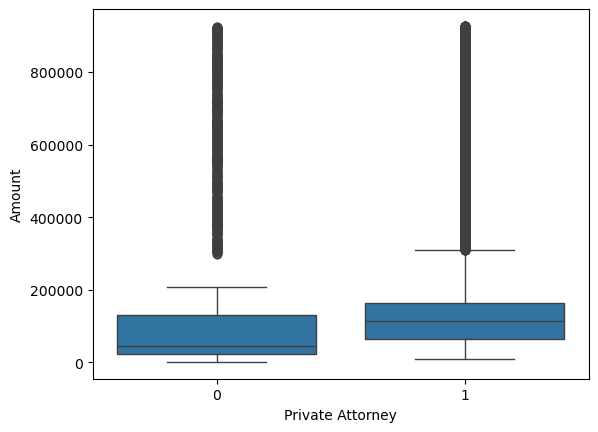

In [76]:
sns.boxplot(df, x = 'Private Attorney', y = 'Amount')

Claimants with private attorneys have a higher distribuition of payments. Still we see that our data is skewed right and there are many outliers in the Amount column

#### Marital Status

Since the Marital Status contains categorical numbers and not scalar values. The mean doesn't tell us anything useful. Let's convert the values in this column back to their string names

In [28]:
status_dict = {   
                0 : 'Divorced',
                1 : 'Single',
                2 : 'Married',
                3 : 'Widowed',
                4 : 'Unknown'
                }

df['Marital Status'] = df['Marital Status'].map(status_dict)

In [29]:
df['Marital Status'].value_counts()

Marital Status
Married     41220
Single      22802
Unknown     10362
Divorced     3832
Widowed       994
Name: count, dtype: int64

The most common marital status amongst claimants is Married, followed by Single, Unknown, Divorced, and Widowed

<Axes: xlabel='Marital Status', ylabel='Count'>

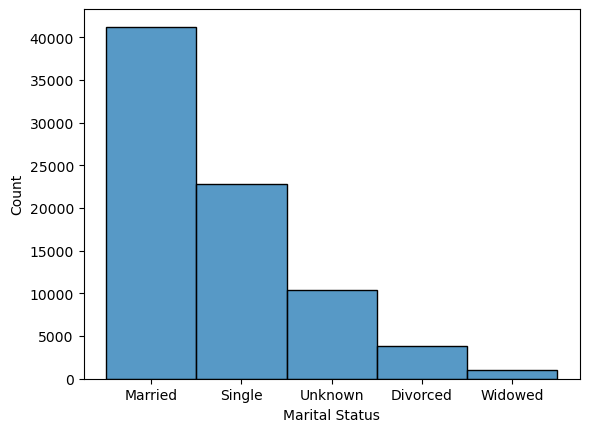

In [30]:
sns.histplot(df['Marital Status'])

<Axes: xlabel='Marital Status', ylabel='Age'>

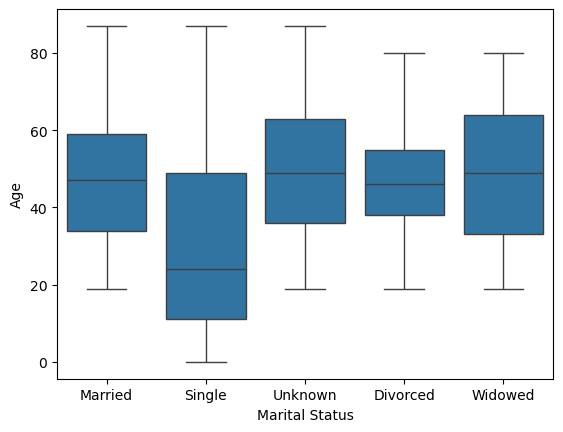

In [31]:
sns.boxplot(df, x = 'Marital Status', y = 'Age')

Looking again at Age, we see that claimants with a marital status of Single on average are younger, and encompass a broader range of ages.

In [32]:
df.groupby('Marital Status')['Age'].describe().T

Marital Status,Divorced,Married,Single,Unknown,Widowed
count,3832.000000,41220.000000,22802.000000,10362.000000,994.000000
mean,46.514614,47.027147,30.754671,49.804478,48.661972
std,12.273627,16.073472,22.723027,17.357141,18.161090
min,19.000000,19.000000,0.000000,19.000000,19.000000
25%,38.000000,34.000000,11.000000,36.000000,33.000000
50%,46.000000,47.000000,24.000000,49.000000,49.000000
75%,55.000000,59.000000,49.000000,63.000000,64.000000
max,80.000000,87.000000,87.000000,87.000000,80.000000


#### Specialty

The Specialty column contains information regarding the practice area of the healthcare provider.

In [33]:
df.Specialty.describe()

count               79210
unique                 20
top       Family Practice
freq                11436
Name: Specialty, dtype: object

There are 20 different types of medical providers in our data with the most common being Family Pratice.

In [34]:
df.Specialty.value_counts()

Specialty
Family Practice           11436
General Surgery            9412
OBGYN                      8876
Anesthesiology             8732
Orthopedic Surgery         7272
Internal Medicine          5223
Neurology/Neurosurgery     4737
Emergency Medicine         4676
Ophthamology               3289
Cardiology                 2659
Urological Surgery         2027
Resident                   1983
Radiology                  1979
Pediatrics                 1416
Dermatology                1384
Plastic Surgeon            1364
Occupational Medicine       725
Pathology                   714
Thoracic Surgery            664
Physical Medicine           642
Name: count, dtype: int64

Another opportunity for aggregation would be to group the physician specialties by Surgeon and Non-surgeon. Below, we'll iterate through the unique specialties and assign a boolean value of 1 for specialties who are surgeons.

In [35]:
for val in df.Specialty.unique():
    if 'surge' in val.lower():
        df.loc[df.Specialty == val,'Surgeon'] = 1
    else:
        df.loc[df.Specialty == val,'Surgeon'] = 0

In [36]:
df.Surgeon.describe()

count    79210.000000
mean         0.321626
std          0.467103
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Surgeon, dtype: float64

About 32% of our data is for claims from healthcare providers who are surgeons.

#### Insurance

The insurance column is another categorical column that provides information on the type of the claimant's health insurance.

In [37]:
df.Insurance.describe()

count       79210
unique          5
top       Private
freq        34289
Name: Insurance, dtype: object

In [38]:
df.Insurance.value_counts()

Insurance
Private                 34289
Unknown                 24052
Medicare/Medicaid       10882
No Insurance             8002
Workers Compensation     1985
Name: count, dtype: int64

The most common insurance type is Private, and a large portion of our data contains an insurance type of Unknown

#### Gender

We saw before when reveiwing the difference of ages between male and female claimants, that our data contains more claimants who are Female.

In [39]:
df.groupby('Gender').Age.describe().T

Gender,Female,Male
count,47770.000000,31440.000000
mean,39.167448,48.072074
std,21.420559,15.615303
min,0.000000,21.000000
25%,21.000000,36.000000
50%,39.000000,47.000000
75%,57.000000,59.000000
max,80.000000,87.000000


<Axes: xlabel='Gender', ylabel='Count'>

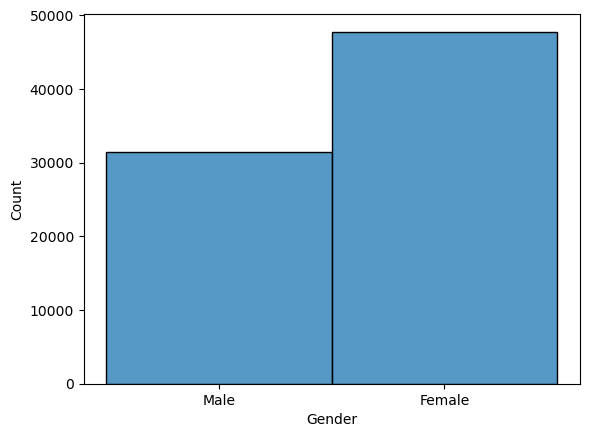

In [40]:
sns.histplot(df.Gender)

The difference between male and female claimants represents another data balance issue in our data, we have roughly 1.5x the data for female claimants compared to male ones. 

Here is another opportunity to create a new column named Female, assign a value of 1 for Females and 0 for Males. 

In [41]:
df.loc[df.Gender == 'Male', 'Female'] = 0
df.loc[df.Gender == 'Female', 'Female'] = 1

df.Female.describe()

count    79210.000000
mean         0.603080
std          0.489262
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Female, dtype: float64

Our data is made up of 60% claimants who are female.

## Data Cleaning

In [42]:
df.head()

,Amount,Severity,Age,Private Attorney,Marital Status,Specialty,Insurance,Gender,large_pmt,Surgeon,Female
0,57041,7,62,1,Married,Family Practice,Private,Male,0,0.0,0.0
1,324976,6,38,1,Married,OBGYN,No Insurance,Female,1,0.0,1.0
2,135383,4,34,1,Married,Cardiology,Unknown,Male,0,0.0,0.0
3,829742,7,42,1,Single,Pediatrics,No Insurance,Female,1,0.0,1.0
4,197675,3,60,0,Married,OBGYN,Medicare/Medicaid,Female,0,0.0,1.0


#### Removing Duplicate rows

In [43]:
df[df.duplicated(keep=False)]

,Amount,Severity,Age,Private Attorney,Marital Status,Specialty,Insurance,Gender,large_pmt,Surgeon,Female
24986,15739,3,31,0,Married,Emergency Medicine,No Insurance,Male,0,0.0,0.0
52859,15739,3,31,0,Married,Emergency Medicine,No Insurance,Male,0,0.0,0.0


Our data contains one instance of a duplicated claim. Let's remove this from our data set and keep only the first one.

In [44]:
df.drop_duplicates(keep = 'first', inplace = True)
df.reset_index(drop = True, inplace = True)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79209 entries, 0 to 79208
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Amount            79209 non-null  int64  
 1   Severity          79209 non-null  int64  
 2   Age               79209 non-null  int64  
 3   Private Attorney  79209 non-null  int64  
 4   Marital Status    79209 non-null  object 
 5   Specialty         79209 non-null  object 
 6   Insurance         79209 non-null  object 
 7   Gender            79209 non-null  object 
 8   large_pmt         79209 non-null  int64  
 9   Surgeon           79209 non-null  float64
 10  Female            79209 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 6.6+ MB


#### Checking for null values

In [46]:
df.isnull().sum()

Amount              0
Severity            0
Age                 0
Private Attorney    0
Marital Status      0
Specialty           0
Insurance           0
Gender              0
large_pmt           0
Surgeon             0
Female              0
dtype: int64

While our we don't have any null values, we should be aware that both the Insurance and Marital Status columns contain information coded as 'unknown' which we may want to exclude from our analysis.

In [47]:
df[df == 'Unknown'].notnull().sum()

Amount                  0
Severity                0
Age                     0
Private Attorney        0
Marital Status      10362
Specialty               0
Insurance           24052
Gender                  0
large_pmt               0
Surgeon                 0
Female                  0
dtype: int64

#### Outliers

As discussed before, the distribution of the Amount column is skewed right. We added a column `large_pmt` to seperate our groups at the cut-off amount of 200,000 dollars. For our analysis, we'll analyze our dataset as a whole, and individually for each group.

#### Other Modifications

To recap, we made a few other modifications to our data set including:
- Converting the categorical coding in the `Marital Status` column from numeric to the specific names for each category.
- Adding the `Surgeon` column, which is a 1 if the Specialty is a surgeon and a 0 otherwise.
- Adding the `Female` column, which is a 1 if the claimant is female, and 0 if the claimant is male.

In [48]:
df.to_csv('./output_data/df_cleaned.csv')

## EDA

### Feature Correlation

The `.corr` function will give us the pearson-coefficient or r value between 2 columns in our data frame. The r value provides information regarding the strength and direction of a linear relationship. Let's run a baseline correlation analysis of our data set at this point before incorporating our categorical columns.

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79209 entries, 0 to 79208
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Amount            79209 non-null  int64  
 1   Severity          79209 non-null  int64  
 2   Age               79209 non-null  int64  
 3   Private Attorney  79209 non-null  int64  
 4   Marital Status    79209 non-null  object 
 5   Specialty         79209 non-null  object 
 6   Insurance         79209 non-null  object 
 7   Gender            79209 non-null  object 
 8   large_pmt         79209 non-null  int64  
 9   Surgeon           79209 non-null  float64
 10  Female            79209 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 6.6+ MB


We'll need to select only the columns that contain a numeric value.

<Axes: >

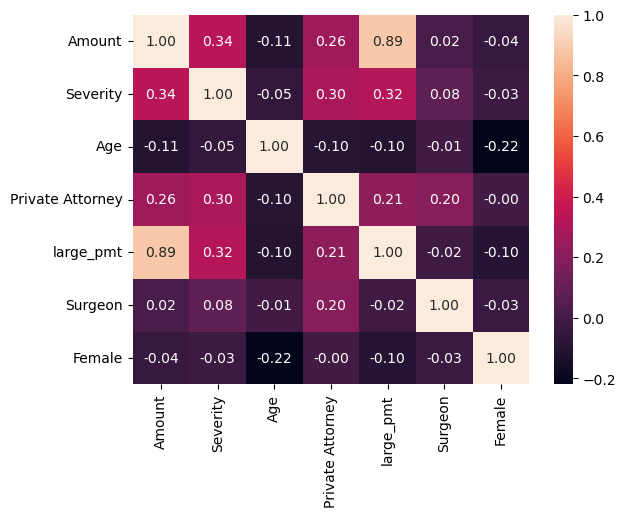

In [50]:
r_val_baseline = df.drop(['Specialty','Insurance','Gender','Marital Status'], axis = 1).corr()
sns.heatmap(r_val_baseline, annot = True, fmt='.2f')

Observations:

- large_pmt is a derived feature of the Amount column and should be excluded from our analysis.
- Severity and Amount show a moderate positive correlation with an r value of .34
- Private Attorney and Severity show a moderate positive correlation with an r value of .30
- Private Attorney and Amount show a weak positive correlation with an r value of .26
- Private Attorney and Surgeon show a weak positive correlation with an r value of .20
- Female and Age show a weak negative correlation with an r value of -.22. This is likely explained to the difference of age distributions between male and female claimants we observed earlier.

### Feature Correlation Using One-Hot Encoding

Let's assign numeric values to our categorical data using the One-Hot Encoding method. This method creates binary columns to the dataset for each category and assigns a 1 if the category is true and a 0 otherwise. 

We'll preform one-hot encoding for our categorical columns of `Specialty`, `Insurance`, and `Marital Status`. We already performed this transformation to the `Gender` column with the addition of the `Female` column.

In [51]:
#Getting dummy values
dum = pd.get_dummies(df[['Specialty','Insurance','Marital Status']], dtype=int)
dum.head()

,Specialty_Anesthesiology,Specialty_Cardiology,Specialty_Dermatology,Specialty_Emergency Medicine,Specialty_Family Practice,Specialty_General Surgery,Specialty_Internal Medicine,Specialty_Neurology/Neurosurgery,Specialty_OBGYN,Specialty_Occupational Medicine,...,Insurance_Medicare/Medicaid,Insurance_No Insurance,Insurance_Private,Insurance_Unknown,Insurance_Workers Compensation,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Marital Status_Unknown,Marital Status_Widowed
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0


In [52]:
#Creating a new dataframe containing both the original data and dummy variables
dum_df = pd.concat([df,dum], axis=1)
dum_df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79209 entries, 0 to 79208
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Amount                            79209 non-null  int64  
 1   Severity                          79209 non-null  int64  
 2   Age                               79209 non-null  int64  
 3   Private Attorney                  79209 non-null  int64  
 4   Marital Status                    79209 non-null  object 
 5   Specialty                         79209 non-null  object 
 6   Insurance                         79209 non-null  object 
 7   Gender                            79209 non-null  object 
 8   large_pmt                         79209 non-null  int64  
 9   Surgeon                           79209 non-null  float64
 10  Female                            79209 non-null  float64
 11  Specialty_Anesthesiology          79209 non-null  int32  
 12  Spec

In [53]:
#Removing non-numeric columns and creating a new dataframe containing the r-values
r_vals = dum_df.drop(['Specialty','Insurance','Gender','Marital Status'],axis=1).corr()

<Axes: >

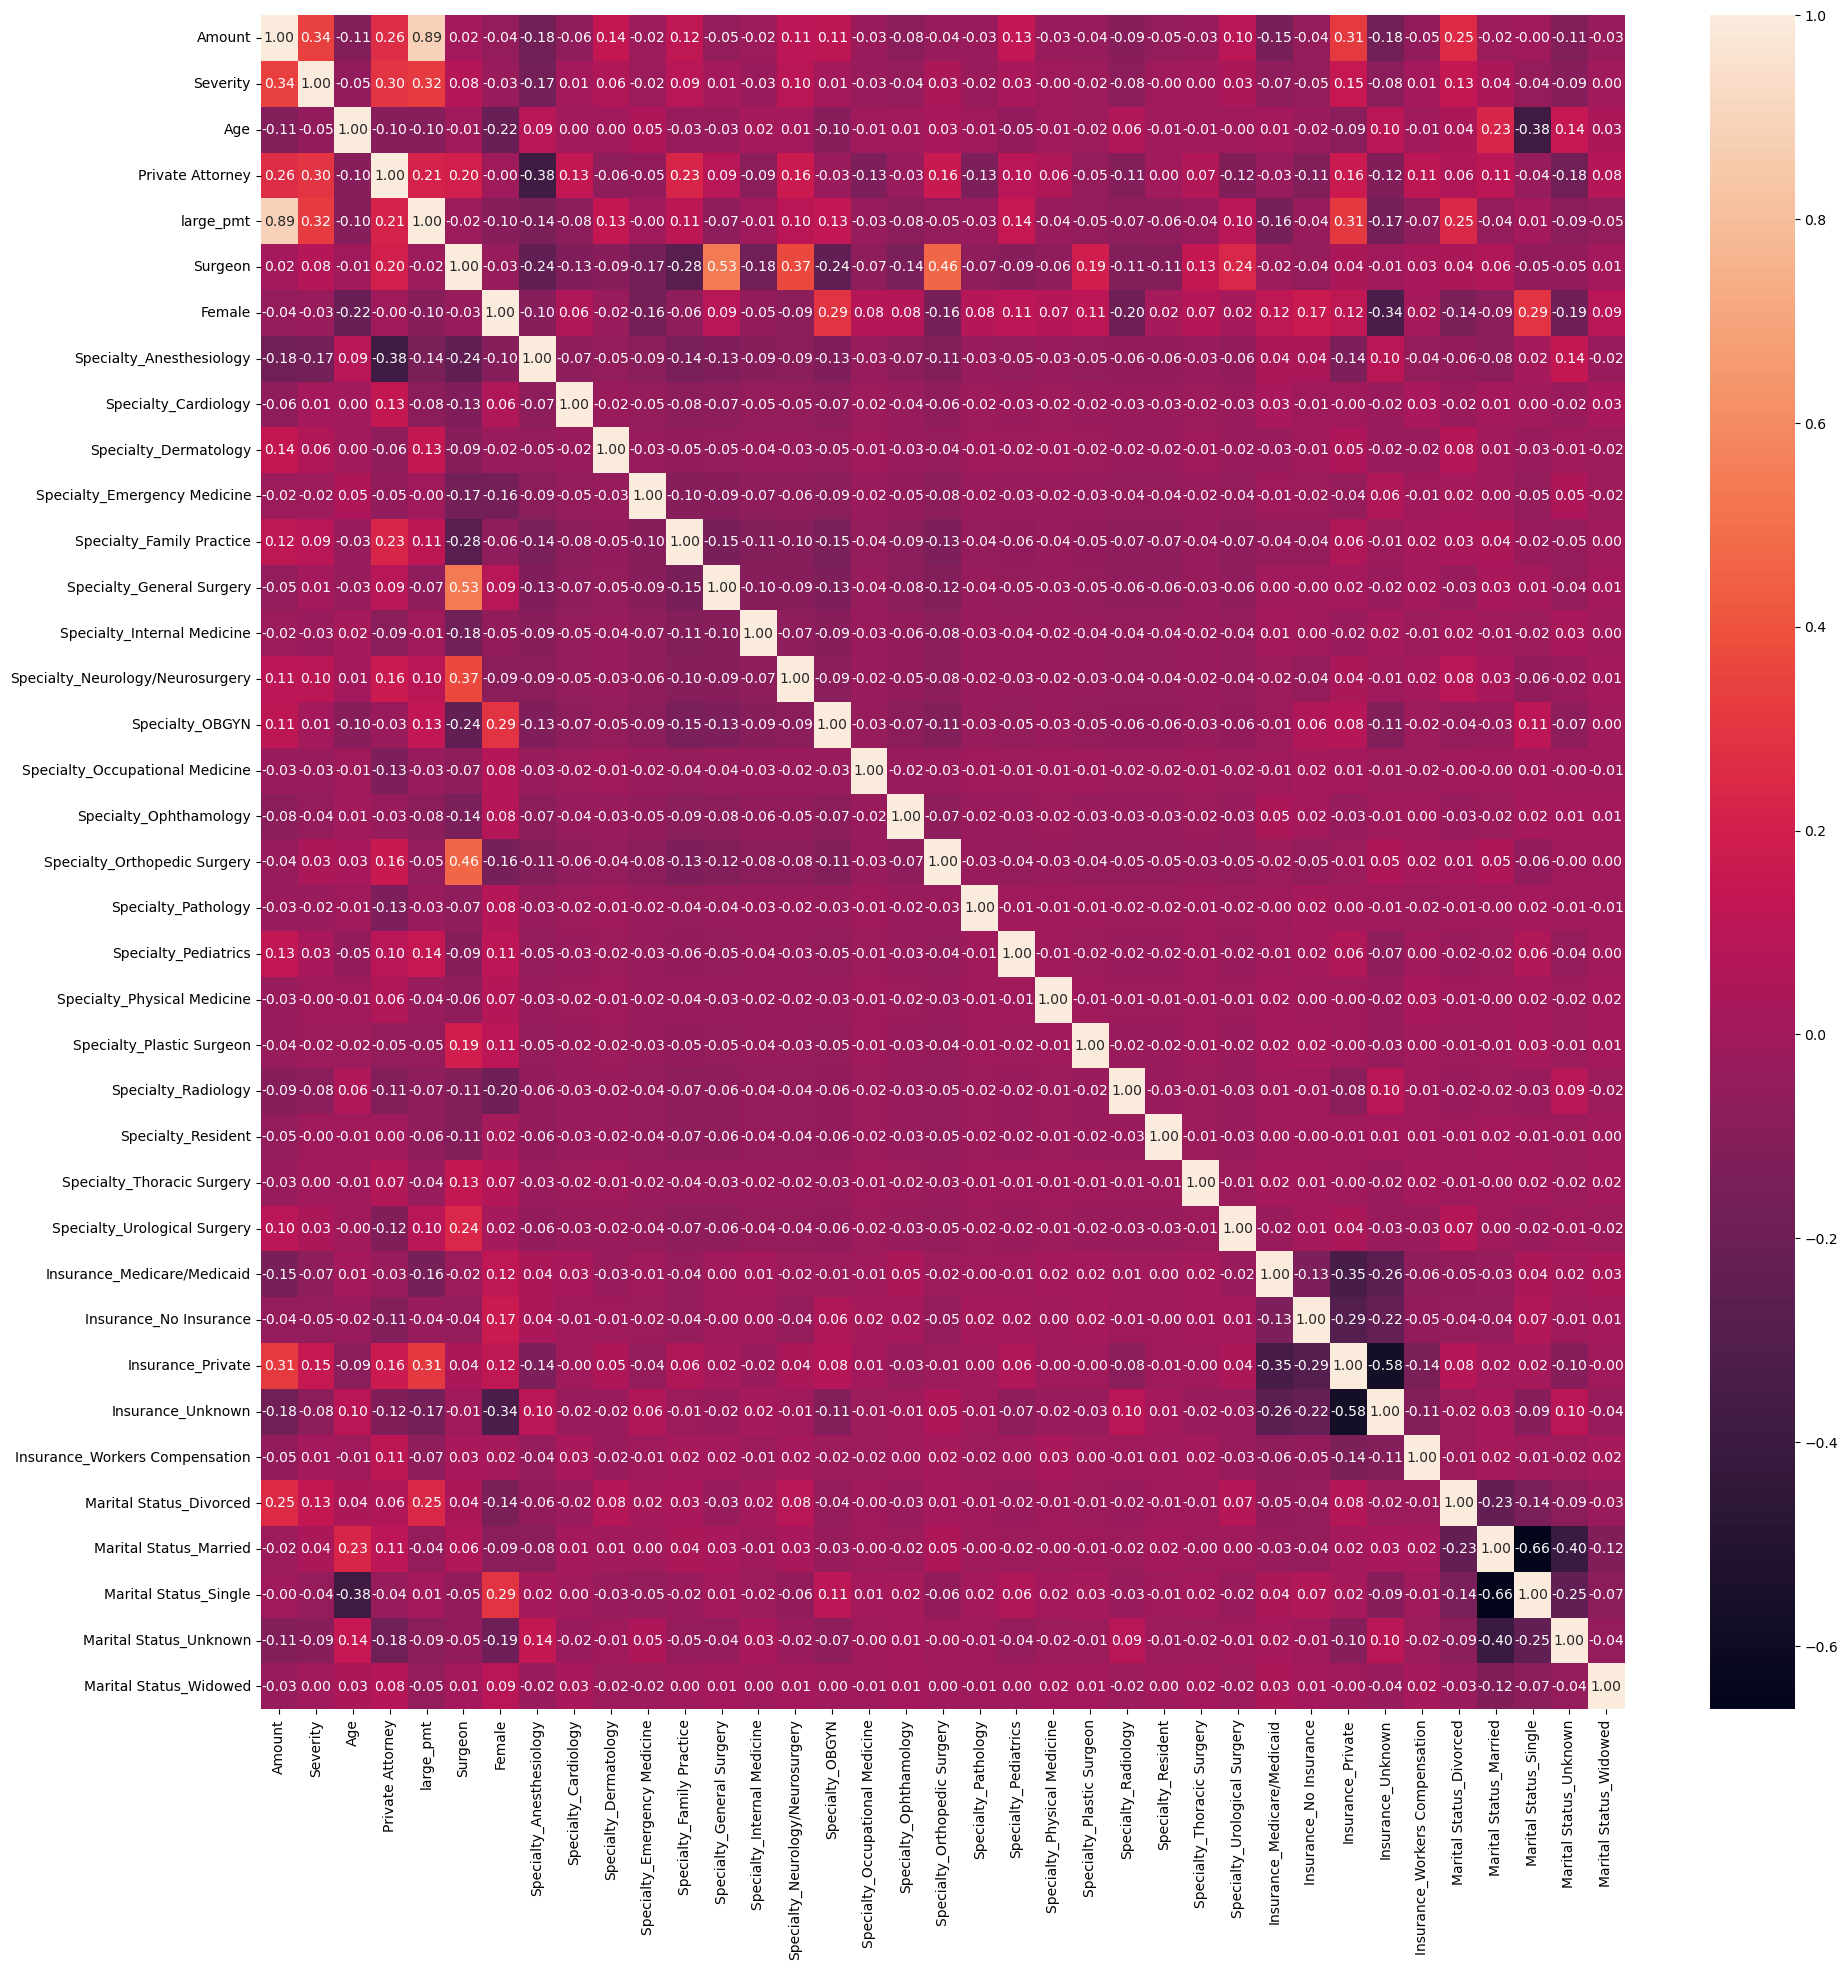

In [54]:
fig, ax = plt.subplots(figsize=(22,22)) 

sns.heatmap(r_vals, ax=ax, annot = True, fmt='.2f')

Observations:
- The Surgeon column is derived from Specialty, and should be excluded from any analysis from a Specialty column.
- Amount and Private Insurance show a moderate positive correlation with an r value of .31.
- Amount and Divorced show a weak positive correlation with an r value of .25
- Age and Married show a weak positive correlation with an r value of .23. Conversely, Age and Single show a moderate negative correlation with r value
  of -.38. This fits reasoning as people are more likely to get married as they get older.
- Interestingly, there is a moderate negative correlation between Private Attorney and Anesthesiology with an r value of -.38. I'm curious if there is    a reasoning that explains this.
- Private Attorney and Family Practice show a weak positive correlation with an r value of .23
- Female and OBGYN shows a moderate positive correlation with an r value of .29. Which follows reasoning since OBGYN physicians provide healthcare     specificly for women
- Female and Unkown Insurance show a moderate negative correlation with an r value of -.34
- Female and Single show a moderate positive correlation of .29. This is likely due to there are more young female claimants in our data set.

### Questions for Analysis

1. The top 4 strongest correlation features with Amount were: Severity, Private Insurance, Private Attorney, and Divorced. Do these features differ when grouping the data between large payments and small payments?
2. Is there a statistical difference in payments made based on Gender?
3. Can we create an accurate regression model that can predict Amount? 

### Question 1

Let's create a new dataframe that includes the r-squared values for our entire original data set. The r-squared value shows the strength of the feature's relationship and ignores the positive or negative directionality.

In [55]:
r2_values=r_vals ** 2
r2_values.Amount.sort_values(ascending = False).head(10)

Amount                         1.000000
large_pmt                      0.789582
Severity                       0.113675
Insurance_Private              0.098639
Private Attorney               0.068590
Marital Status_Divorced        0.062487
Insurance_Unknown              0.032759
Specialty_Anesthesiology       0.031309
Insurance_Medicare/Medicaid    0.022340
Specialty_Dermatology          0.018553
Name: Amount, dtype: float64

Now let's separate our data for payments above and below 200,000 using the `large_pmt` column, and calculate the r-squared values to find the strongest correlations with `Amount`.

In [56]:
#Separating our data into two groups
low_pmt=dum_df[dum_df.large_pmt == 0]
low_pmt.reset_index(drop = True, inplace = True)

high_pmt=dum_df[dum_df.large_pmt == 1]
high_pmt.reset_index(drop = True, inplace = True)

In [57]:
#Creating two seperate dataframes containing r-squared values
low_features = low_pmt.drop(['Specialty','Insurance','Gender','Marital Status'],axis=1).corr() ** 2
high_features = high_pmt.drop(['Specialty','Insurance','Gender','Marital Status'],axis=1).corr() ** 2

In [58]:
low_features.Amount.sort_values(ascending = False)

Amount                              1.000000
Female                              0.128521
Private Attorney                    0.045516
Specialty_Anesthesiology            0.037819
Marital Status_Unknown              0.023055
Insurance_Unknown                   0.021597
Specialty_Radiology                 0.017899
Insurance_Private                   0.017840
Severity                            0.015093
Age                                 0.012980
Surgeon                             0.010267
Specialty_OBGYN                     0.007659
Specialty_Emergency Medicine        0.006136
Specialty_General Surgery           0.006105
Marital Status_Married              0.003407
Specialty_Family Practice           0.003132
Specialty_Urological Surgery        0.002638
Specialty_Internal Medicine         0.002178
Specialty_Plastic Surgeon           0.001817
Specialty_Occupational Medicine     0.001278
Specialty_Cardiology                0.001192
Marital Status_Single               0.001173
Specialty_

In [59]:
high_features.Amount.sort_values(ascending = False)

Amount                              1.000000
Female                              0.059987
Private Attorney                    0.050900
Severity                            0.033982
Specialty_Anesthesiology            0.025539
Insurance_Medicare/Medicaid         0.021969
Marital Status_Single               0.014814
Marital Status_Divorced             0.010119
Specialty_Pathology                 0.008977
Age                                 0.008870
Specialty_OBGYN                     0.008490
Specialty_Resident                  0.007181
Insurance_No Insurance              0.007163
Specialty_Plastic Surgeon           0.006883
Specialty_Ophthamology              0.006600
Insurance_Private                   0.006451
Specialty_Neurology/Neurosurgery    0.005762
Specialty_Occupational Medicine     0.004779
Specialty_Orthopedic Surgery        0.004599
Specialty_General Surgery           0.003728
Surgeon                             0.003087
Specialty_Dermatology               0.002730
Specialty_

Amongst our entire dataset the strongest top 4 features with Amount were: Severity, Private Insurance, Private Attorney, and Divorced.
Amongst our low payment group the strongest top 4 features with Amount were: Female, Private Attorney, Anesthesiology, and Unknown Marital Status.
Amongst our high payment group the strongest top 4 features with Amount were: Female, Private Attorney, Severity, and Anesthesiology.

There is a difference between the strongest correlation features with Amount between high payment and low payment groups. Private Attorney is common between all groups. Female and Anesthesiology are present in the high and low payment groups.

### Question 2

For this question we need to find if there is a statisical difference between the `Amounts` based on Gender. Let's first determine which statistical test to use.

In [60]:
df.groupby('Female')['Amount'].describe().T

Female,0.0,1.0
count,31439.000000,47770.000000
mean,167406.130793,150957.808290
std,234899.767404,159467.182911
min,1576.000000,1578.000000
25%,28415.000000,63112.500000
50%,66578.000000,111449.500000
75%,142950.500000,159819.500000
max,926411.000000,851373.000000


It appears that the mean for male payments is higher than female payments. The median for female payments is higher than male payments. Is there a difference in the distribution between these two groups?

<Axes: xlabel='Amount', ylabel='Count'>

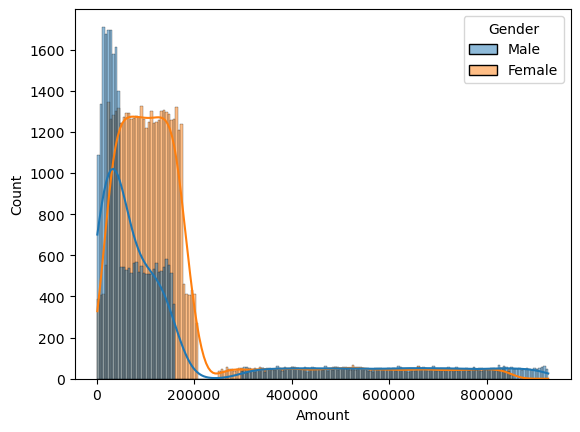

In [61]:
sns.histplot(df, x = 'Amount', hue = 'Gender', kde = True)

The histogram plot once again shows us that our data is right skewed. Since one of the assumptions of t-testing is that our distribution is normal, we should use another statistical test in order to see if there is a statisical difference in our two groups. In this case, we should use a Mann-Whitney test. The Mann-Whitney test is a non-parametric test that tests differences based on rank, which makes it robust to skewedness.

Our hypothesis test will be as follows:

* $H_0$: $U_M$ - $U_F$ =      0 - Null Hypothesis: There is no difference between Amounts paid to Male and Female claimants.
* $H_A$: $U_M$ - $U_F$ $\neq$   0 - Alternative Hypothesis: There is a significant difference in Amounts paid to Male and Female claimants
* Our P-value will be 5%

In [62]:
from scipy.stats import mannwhitneyu

amount_m = df.loc[df.Female == 0, 'Amount'].to_numpy()
amount_f = df.loc[df.Female == 1, 'Amount'].to_numpy()

print(amount_m.shape)
print(amount_f.shape)


U, P = mannwhitneyu(amount_m, amount_f, alternative = 'two-sided')
print(f"The U value is {U}")
print(f"The P statistic is {P}")

(31439,)
(47770,)
The U value is 575987521.5
The P statistic is 0.0


We can see, our P stat is nearly 0, which means we strongly reject the null hypothesis that the two distributions are the same.

### Question 3

Let's attempt to build a linear regression model using our data to predict our amount. Let's review the strongest correlation features we have currently:

In [63]:
r2_values.Amount.sort_values(ascending = False)

Amount                              1.000000
large_pmt                           0.789582
Severity                            0.113675
Insurance_Private                   0.098639
Private Attorney                    0.068590
Marital Status_Divorced             0.062487
Insurance_Unknown                   0.032759
Specialty_Anesthesiology            0.031309
Insurance_Medicare/Medicaid         0.022340
Specialty_Dermatology               0.018553
Specialty_Pediatrics                0.016267
Specialty_Family Practice           0.014075
Marital Status_Unknown              0.013031
Specialty_OBGYN                     0.012833
Specialty_Neurology/Neurosurgery    0.011972
Age                                 0.011088
Specialty_Urological Surgery        0.009987
Specialty_Radiology                 0.008635
Specialty_Ophthamology              0.005989
Specialty_Cardiology                0.003734
Insurance_Workers Compensation      0.002717
Specialty_Resident                  0.002643
Specialty_

Amount is our dependant variable, let's use the top 4 features for our independant variables: Severity, Private Insurance, Private Attorney, and Divorced to train our data

In [64]:
#Importing Necessary Functions
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Below we split our dependant variables and independant variables into two groups:

In [65]:
X = dum_df[['Severity','Insurance_Private','Private Attorney','Marital Status_Divorced']]
Y = dum_df[['Amount']]

#Creating training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

#Fitting the linear regression model with training data
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [66]:
#Defining functions to assist in graphing and testing
def graph(exp,predict):
    tempdf=pd.DataFrame(columns=['Actual','Predicted'])
    tempdf['Actual']=exp
    tempdf['Predicted']=predict
    sns.displot(tempdf, kind = 'kde')
    
def test(model, x, y):
    prediction = model.predict(x)
    RMSE=np.sqrt(mean_squared_error(y,prediction))
    score=r2_score(y, prediction)
    graph(y, prediction)
    print(f"The RMSE is: {round(RMSE,4)} The r2 score is: {round(score,4)}")


Testing the Output from our Training Data:

The RMSE is: 168192.5282 The r2 score is: 0.2398


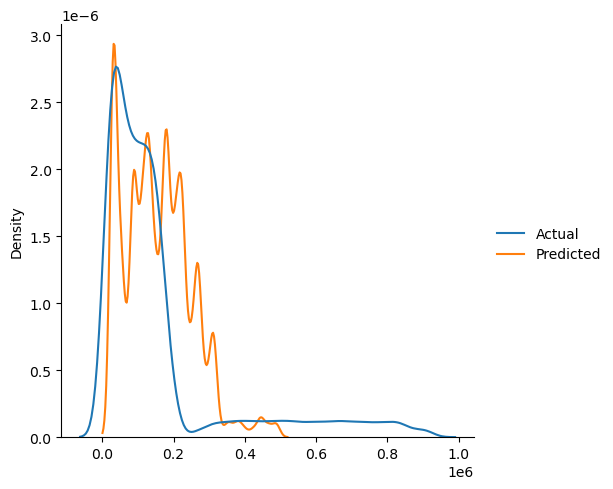

In [67]:
test(lr, x_train, y_train)

The output of our model has an r-squared value of .24, which is pretty low, even when using the training data for predictions.

Let's evaluate how our model does on testing data:

The RMSE is: 169571.4304 The r2 score is: 0.2363


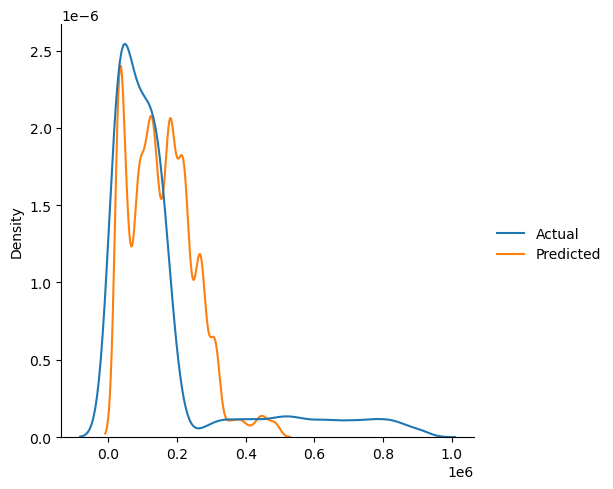

In [68]:
test(lr, x_test, y_test)

As we can see, our model has a similar r-squared value of .23 and a pretty high error rate. Let's attempt to improve our results using a different regressor

#### Decision Tree Regressor

Next, lets try a decision tree regressor for our predictions. A decision tree uses a different method for making predictions and is non-linear, by dividing the data into subgroups, and taking the average at each subgroup. Since we don't have a strong linear relationship for the Amount column, this may improve our results.

In [69]:
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train,y_train)

DecisionTreeRegressor()

Testing the model on our training data:

The RMSE is: 156166.6588 The r2 score is: 0.3446


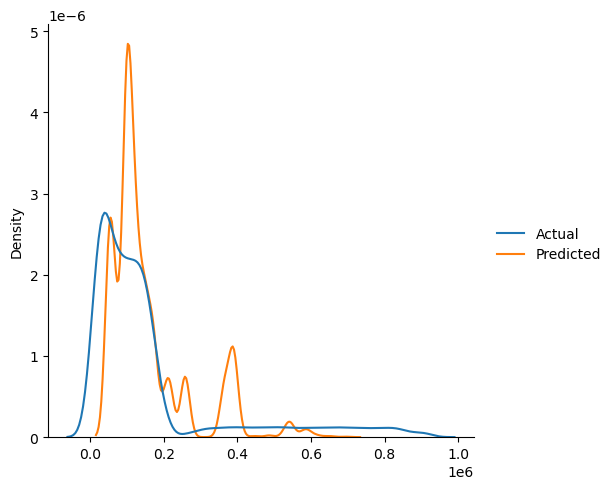

In [70]:
test(dec_tree, x_train, y_train)

We can see that our model had slightly better results, and returned with an r-squared value of .35, which is an improvement over .24 we saw using linear regression.

Testing our model on testing data:

The RMSE is: 157125.8792 The r2 score is: 0.3443


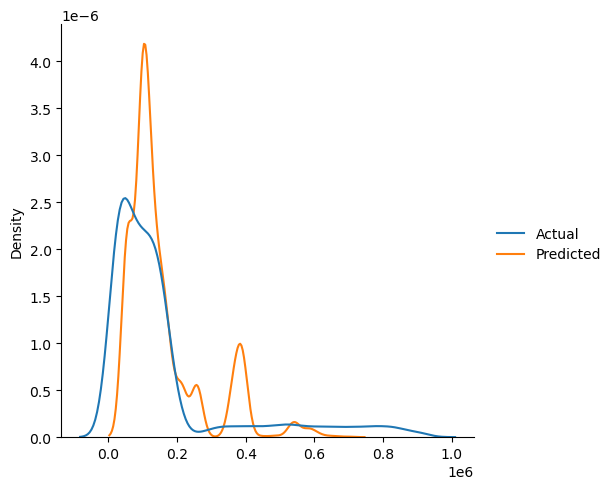

In [71]:
test(dec_tree, x_test, y_test)

On our testing data, our model had similar results with an r-squared value of .33.

## Conclusions

The ability of our predictive model improved slightly when using the Decision Tree Regressor as compared to the Linear Regressor. Nevertheless, our models don't seem to provide highly accurate results. 

Working with the data set, I believe there's room for improvement. There are a few areas of data imbalance that may be impacting our capacity for accurate prediction. 
- Our data set is imblacanced when it comes to Gender, Private Attorney, and Private Insurace. As a result, our data may be bias towards over-represented columns.
- Our data set contains many Unknown values in the Marital Status column and Insurance column.
- I question the quality of the severity column. There is no information provided about how that number is calculated, or whether it is a self-reported number from claimants. I suspect that having more robust data regarding severity could contribute as a stronger predictor of Amount.
- The lack of strong correlation with the Amount column proves difficult when it comes to predictive capacity. None of our features had a pearson coefficient higher than .7, which would provide a clearer predictive capacity when it comes to regression.
- The distribution of the Amount column is not smoothly distributed. There seems to be a cut-off around 200,000 which may indicate that this data was gathered from multiple sources.
- The age distribution between male and female claimants also varies. For female claimaints, we had a range of ages from 0 to 80, for male claiants, the range of ages was between 21 and 87. I suspect there is missing data here, as there is likely medical malpractice that occurs for men under the age of 21.
- I'm interested in why there is a moderate negative correlation between attorney representation and anestesiologists. My hypothesis is that anestesiologists work alongside surgeons, who may have a higher responsibility to the patient or generally higher malpractice insurance policies. Attorneys may seek to file suit against the surgeon due to a clearer causality and duty for care, or to receive a higher payout from a larger insurance policy.